In [0]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
  from sklearn.feature_extraction.text import TfidfVectorizer
  from sklearn.cluster import KMeans

In [0]:
listings = pd.read_csv('listings_with_label.csv',index_col=[0])

In [0]:
neighborhoods = pd.read_csv('neighbourhoods.csv')

In [0]:
reviews = pd.read_csv('reviews.csv',index_col=[0])

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
reviews['date'] = pd.to_datetime(reviews['date'])

In [0]:
reviews[reviews['date']>='1/1/2015']

,listing_id,id,date,reviewer_id,reviewer_name,comments
15,2595,28794060,2015-03-30,27436102,Kellie,Jennifer was very good at communicating with u...
16,2595,30430122,2015-04-21,6429364,Sonya,I love this space. It is truly a gem in the h...
17,2595,32532759,2015-05-19,12146524,Michiel,"This was our first Airbnb experience, and Jenn..."
18,2595,47785650,2015-09-21,12885233,Lin,"Great location, in the middle of everything. T..."
19,2595,48764464,2015-09-28,18636130,Alex,"Jennifer was without doubt an amazing host, sh..."
...,...,...,...,...,...,...
1226549,43300250,623346082,2020-04-29,332274505,Rocco,Wonderful place and an perfect location. The p...
1226550,43320440,624021540,2020-05-05,318190347,Kaj,Great time !
1226551,43320440,624146251,2020-05-07,278355992,Joseph,Immediate responses! Very cool place!
1226552,43325856,623942318,2020-05-04,18351733,Adrielle,The photos don’t do this place justice! This p...


In [0]:
listings['neighbourhood'].value_counts()

In [0]:
Manhattan = listings[listings['listing_id']=='Manhattan']['id'].to_list()

In [0]:
safe_manhattan = reviews[(reviews['neighborhood'].isin(Mid_East)) & (reviews['comments'].str.contains('safe'))]

In [0]:
neighborhoods_list = neighborhoods['neighbourhood']

In [0]:
safe_ids = safe_manhattan['listing_id'].unique()

In [0]:
safe_listings = listings[listings['id'].isin(safe_ids)]

In [0]:
! conda install geopandas

/bin/bash: conda: command not found


In [0]:
!install geopandas

install: missing destination file operand after 'geopandas'
Try 'install --help' for more information.


In [0]:
! pip install geopandas

In [0]:
import matplotlib.pyplot as plt

In [0]:
BBox = ((safe_listings.longitude.min(),   safe_listings.longitude.max(),      
         safe_listings.latitude.min(), safe_listings.latitude.max()))

In [0]:
ruh_m = plt.imread('map.png')

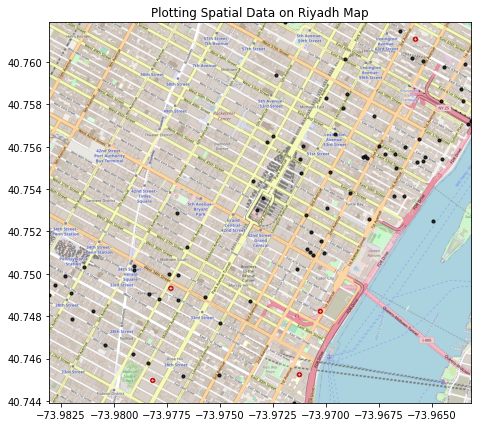

In [0]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(safe_listings.longitude, safe_listings.latitude, zorder=1, alpha= 0.8, c='black', s=10)
ax.set_title('Plotting Spatial Data on Riyadh Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')


In [0]:
BBox

(-73.98307, -73.96313, 40.74391, 40.76188)

In [0]:
safe_listings.longitude.min()

-73.98307

In [0]:
ids = listings[listings['neighbourhood'].isin(neighborhoods_list)]['id'].to_list()

In [0]:
reviews[(reviews['listing_id'].isin(ids)) & (reviews['comments'].str.contains("neighborhood"))]

In [0]:
def review_contains_word(word):
  ids = listings[listings['neighbourhood'].isin(neighborhoods_list)]['id'].to_list()
  review = reviews[(reviews['listing_id'].isin(ids)) & (reviews['comments'].str.contains(word))]
  listing_contains_word = review['listing_id'].unique()

  return listing_contains_word

In [0]:
review_contains_word("peaceful")

array([    3831,     5203,     5803, ..., 42434784, 42597821, 42808495])

# Data Cleaning and Text Processing

In [0]:
listings = listings[listings['neighborhood_overview'].notna()]

In [0]:
listings = listings[['id','name','summary','space','description','neighborhood_overview','transit',
          'access','neighbourhood','neighbourhood_cleansed','zipcode','market','latitude','longitude',
         'room_type','property_type','number_of_reviews','review_scores_rating','review_scores_location']]

In [0]:
reviews_with_nb = pd.merge(reviews, listings, left_on='listing_id', right_on='id')

In [0]:
### Pre cleaning:
"""
    +1. Remove all neighborhood names
    +1. Remove all boro names
    +1. Remove all other unnecessary words
  """
boro_names = neighborhoods['neighbourhood_group'].unique().tolist()
boro_names = list(map(lambda x:x.lower(),boro_names))
nei_names = neighborhoods['neighbourhood'].unique().tolist()
nei_names = list(map(lambda x:x.lower(),nei_names))
## exclude other unneccessay words
excluded_words = ['ny','neighborhood','neighbourhood','city','nyc','new york',' new york city']

### combine to a list of unwanted words
unwanted_words = boro_names + nei_names + excluded_words


In [0]:
listings['neighborhood_overview'] = listings['neighborhood_overview'].str.lower().replace('|'.join(unwanted_words),'',regex=True)


In [0]:
listings.head(10)['neighborhood_overview'].values

array(['centrally located in the heart of  just a few blocks from all subway connections in the very desirable  location a few minutes walk to times square, the , bryant park and herald square.',
       'just the right mix of urban center and local ; close to all but enough quiet for a calming walk.',
       "my  in  east is called . the area is very centrally located with easy access to explore . the apartment is about 5 blocks (7 minute walk) to the united nations and grand central station the main and most historic train station.  grand central will give you access to every train in the . the apartment is also very close to main attractions, it's about a 10 minute walk to both the empire state building and times square.  there's a great shopping area with dozens of stores including h&m, zara, the gap, bebe and the world famous macy's department store. these shops are a 10 minute walk up east 34th street from 5th avenue and 8th avenue.   if you would like to stay local in the area, t

In [0]:
### Text Preprocessing
"""removes punctuation, stopwords, and returns a list of the remaining words, or tokens"""
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')


import string
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    4. Remove words
    '''
    stemmer = WordNetLemmatizer()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    return [stemmer.lemmatize(word) for word in nopunc]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
listings['neighborhood_overview_processed'] = listings['neighborhood_overview'].apply(lambda x: text_process(x)).apply(lambda x: ', '.join([str(i) for i in x])).str.replace(',','')

In [0]:
listings['neighborhood_overview_processed'].head(3)

1    centrally located heart block subway connectio...
2    right mix urban center local close enough quie...
3    east called area centrally located easy access...
Name: neighborhood_overview_processed, dtype: object

In [0]:
#Vectorisation : -
corpus = []
for index, row in listings.iterrows():
  overview = row.neighborhood_overview_processed
  corpus.append(overview)


In [0]:
listings.shape

(32571, 21)

In [0]:
listings = listings[listings['neighborhood_overview_processed'].notna()]

In [0]:
tfidf_vec = TfidfVectorizer(ngram_range=(1, 3))
review_tfidf_vec = tfidf_vec.fit_transform(corpus)


# NLP -- Unsupervised Classification


### Neighborhood Overview Clusterings
#### Every listing id corresponds to one neighborhood and one neighborhood overview

#### test the clustering

In [0]:
## Clustering the training sentences with K-means technique
## n_clusters = 10, n_init=10

from sklearn.cluster import KMeans
modelkmeans = KMeans(n_clusters=10, init='k-means++', n_init=10)
modelkmeans.fit(review_tfidf_vec)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
order_centroids = modelkmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vec.get_feature_names()

In [0]:
for i in range(10):
 print("Cluster %d:" % i),
 for ind in order_centroids[i, :10]:
  print(' %s' % terms[ind])

Cluster 0:
 restaurant
 bar
 park
 great
 close
 area
 street
 shop
 best
 place
Cluster 1:
 mi
 central
 square
 center
 mi th
 empire state building
 state building
 empire state
 building
 empire
Cluster 2:
 landmark stunning architecture
 hub boasting iconic
 flaunting highrises bustling
 flaunting highrises
 flaunting
 bar stone street
 bustle one sidewalk
 perfect mix fastpaced
 east river flaunting
 suburban living historic
Cluster 3:
 new
 gallery
 nightlife
 find
 store
 art
 dynamic
 thriving
 subway station
 subway
Cluster 4:
 minute
 walk
 minute walk
 min
 park
 train
 square
 min walk
 central
 away
Cluster 5:
 street art
 view
 provides stunning
 provides stunning view
 art
 hip
 stunning view
 drink
 chic
 provides
Cluster 6:
 safe
 quiet
 quiet safe
 friendly
 safe quiet
 safe friendly
 safe cool
 peaceful
 nice quiet
 residential
Cluster 7:
 block
 away
 block away
 park
 restaurant
 one
 store
 one block
 subway
 train
Cluster 8:
 walking distance
 distance
 walking


In [0]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(5,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(review_tfidf_vec)
    Sum_of_squared_distances.append(km.inertia_)


import matplotlib.pyplot as plt


In [0]:
Sum_of_squared_distances.append(modelkmeans.inertia_)

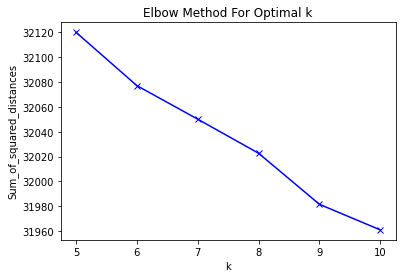

In [0]:

plt.plot([5,6,7,8,9,10], Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [0]:
## Clustering the training sentences with K-means technique
## n_clusters = 9, n_init=10
from sklearn.cluster import KMeans
modelkmeans_9 = KMeans(n_clusters=9, init='k-means++', n_init=10)
modelkmeans_9.fit(review_tfidf_vec)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
 order_centroids9 = modelkmeans_9.cluster_centers_.argsort()[:, ::-1]
terms9 = tfidf_vec.get_feature_names()

In [0]:
for i in range(9):
 print("Cluster %d:" % i),
 for ind in order_centroids9[i, :9]:
  print(' %s' % terms9[ind])

Cluster 0:
 restaurant
 bar
 area
 street
 close
 park
 great
 best
 food
Cluster 1:
 explore feel home
 space explore feel
 explore feel
 perfect space explore
 apartment perfect space
 relaxing book
 perfect space
 visiting hotspot
 visiting hotspot shopping
Cluster 2:
 walking distance
 distance
 walking
 central
 square
 park
 within walking
 within walking distance
 central park
Cluster 3:
 safe
 quiet
 quiet safe
 friendly
 safe quiet
 safe friendly
 residential
 safe cool
 peaceful
Cluster 4:
 minute
 walk
 away
 block
 min
 minute walk
 train
 block away
 park
Cluster 5:
 landmark stunning architecture
 hub boasting iconic
 flaunting highrises bustling
 flaunting highrises
 flaunting
 bar stone street
 bustle one sidewalk
 perfect mix fastpaced
 east river flaunting
Cluster 6:
 find
 nice cafe
 nice
 find almost everything
 almost everything need
 find almost
 almost everything
 asian
 drug store
Cluster 7:
 mi
 mi th
 mi th ave
 art mi
 th ave
 center mi
 park mi
 hidden
 squa

In [0]:
listings['cluster'] = modelkmeans_9.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
listings.head()

,id,name,summary,space,description,neighborhood_overview,transit,access,neighbourhood,neighbourhood_cleansed,zipcode,market,latitude,longitude,room_type,property_type,number_of_reviews,review_scores_rating,review_scores_location,neighborhood_overview_processed,cluster
1,2595,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",centrally located in the heart of just a few ...,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",Manhattan,Midtown,10018,New York,40.75362,-73.98377,Entire home/apt,Apartment,48,94.0,10.0,centrally located heart block subway connectio...,4
2,3831,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,just the right mix of urban center and local ;...,B52 bus for a 10-minute ride to downtown Brook...,"You will have the private, exclusive use of an...",Clinton Hill,Clinton Hill,11238,New York,40.68514,-73.95976,Entire home/apt,Guest suite,318,89.0,9.0,right mix urban center local close enough quie...,0
3,5099,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,my in east is called . the area is very cent...,From the apartment is a 10 minute walk to Gran...,I will meet you upon arrival.,Midtown East,Murray Hill,10016,New York,40.74767,-73.97500,Entire home/apt,Apartment,78,90.0,10.0,east called area centrally located easy access...,4
5,5178,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"You will use one large, furnished, private roo...",Please don’t expect the luxury here just a bas...,", ma restaurants around here.",NaN,Bathroom is shared with the host but the kitch...,Manhattan,Hell's Kitchen,10019,New York,40.76489,-73.98493,Private room,Apartment,473,84.0,10.0,restaurant around,0
6,5203,Cozy Clean Guest Room - Family Apt,"Our best guests are seeking a safe, clean, spa...",Stay in my family's little guest room and enj...,"Our best guests are seeking a safe, clean, spa...",our is full of restaurants and cafes. there ...,The number 1 train stops at 110th Street/Cathe...,Guests will be able to come and go as they nee...,Upper West Side,Upper West Side,10025,New York,40.80178,-73.96723,Private room,Apartment,118,98.0,10.0,full restaurant cafe plenty,0


In [0]:
listings.to_csv('listings_with_label.csv')

In [0]:
corpus[-1]

In [0]:
## Vectorize 
tfidf_vec = TfidfVectorizer(ngram_range=(1, 3))
corpus_vec = tfidf_vec.fit_transform(corpus)

In [0]:
corpus

In [0]:
### topic modeling
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [0]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [0]:
## exclue neighborhood names 
nei_names = neighborhoods['neighbourhood'].tolist()
result = list(map(lambda x:x.lower(),nei_names))
nei_name = set(result)

In [0]:
boro_names

{'bronx', 'brooklyn', 'manhattan', 'queens', 'staten island'}

In [0]:
##exclue borough names
boro_names = neighborhoods['neighbourhood_group'].tolist()
boro_names = list(map(lambda x:x.lower(),boro_names))
boro_names = set(boro_names)

In [0]:
## exclude other unneccessay words
excluded_words = set(['centrally','new', 'york','ny','neighborhood','neighbourhood','city','neighbourhood,','neighborhood,','neighborhood;','nyc'])

In [0]:
excluded_words 

{'centrally', 'city', 'neighborhood', 'neighbourhood', 'new', 'ny', 'york'}

In [0]:
def clean(doc):
    neighborhood_names_free = " ".join([word for word in doc.lower().split() if word not in nei_name])
    borough_names_free = " ".join([word for word in neighborhood_names_free.split() if word not in boro_names])
    excluded_words_free = " ".join([word for word in borough_names_free.split() if word not in excluded_words])
    print(excluded_words_free)
    stop_free = " ".join([word for word in excluded_words_free.split() if word not in stop])
    punc_free = "".join(token for token in stop_free if token not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized


In [0]:
test = listings['neighborhood_overview'].head(300).tolist()

In [0]:
doc_clean = [clean(overview).split() for overview in test]

In [0]:
doc_clean[0:10]

In [0]:
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
corpus = [dictionary.doc2bow(text) for text in doc_clean]

import pickle 

In [0]:
import gensim

# let LDA find 3 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

# uncomment the code if working locally
#ldamodel.save('../input/sentimentData/model3.gensim')

topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.012*"park" + 0.010*"best" + 0.008*"diverse" + 0.007*"hill" + 0.007*"neighborhood"')
(1, '0.013*"restaurant" + 0.011*"•" + 0.010*"block" + 0.010*"walk" + 0.010*"area"')
(2, '0.019*"restaurant" + 0.016*"park" + 0.012*"bar" + 0.010*"music" + 0.010*"place"')
(3, '0.017*"park" + 0.016*"restaurant" + 0.014*"street" + 0.013*"block" + 0.013*"cafe"')
(4, '0.018*"restaurant" + 0.017*"shop" + 0.015*"great" + 0.014*"park" + 0.012*"east"')
(5, '0.018*"east" + 0.013*"street" + 0.012*"restaurant" + 0.011*"lower" + 0.011*"side"')
(6, '0.015*"restaurant" + 0.015*"park" + 0.013*"museum" + 0.012*"bar" + 0.011*"great"')
(7, '0.021*"greene" + 0.018*"fort" + 0.017*"neighborhood" + 0.015*"restaurant" + 0.014*"theater"')
(8, '0.010*"restaurant" + 0.009*"take" + 0.008*"street" + 0.007*"like" + 0.006*"hidden"')
(9, '0.022*"park" + 0.020*"restaurant" + 0.019*"block" + 0.018*"minute" + 0.015*"away"')


## Map the clustering

In [0]:
listings.head(3)

# Classify each neighborhood

In [0]:
listings = pd.read_csv('listings_with_label.csv',index_col=[0]).drop(['neighborhood_overview_vec'],axis=1)

In [0]:
neighborhood_overview_list = dict(zip(listings['neighborhood_overview_processed'], listings['neighbourhood']))

In [0]:
res = {}
for key, val in neighborhood_overview_list.items():
    if val not in res:
      res[val] = [key]
    else:
      res[val].append(key)

In [0]:
neighborhood_overview = pd.DataFrame(list(res.items()), columns=['neighborhood','overviews'])

In [0]:
neighborhood_overview.head(2)

,neighborhood,overviews
0,Manhattan,centrally located heart block subway connectio...
1,Clinton Hill,right mix urban center local close enough quie...


In [0]:
neighborhood_overview['overviews'] = [','.join(map(str, l)) for l in neighborhood_overview['overviews']]

In [0]:
neighborhood_overview['overviews'] = neighborhood_overview['overviews'].str.replace(r"[\"\',]",'')

In [0]:
## vectorize 
#Vectorisation : -
neighborhood_overview_corpus = []
for index, row in neighborhood_overview.iterrows():
  overviews = row.overviews
  neighborhood_overview_corpus.append(overviews)


In [0]:
tfidf_vec_nei = TfidfVectorizer(ngram_range=(1, 3))
nei_review_tfidf_vec = tfidf_vec_nei.fit_transform(neighborhood_overview_corpus)

In [0]:
from sklearn.cluster import KMeans
modelkmeans_nei = KMeans(n_clusters=9, init='k-means++', n_init=10)
modelkmeans_nei.fit(nei_review_tfidf_vec)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
order_centroids_nei = modelkmeans_nei.cluster_centers_.argsort()[:, ::-1]
terms_nei = tfidf_vec_nei.get_feature_names()

In [0]:
len(terms_nei )

929655

In [0]:
for i in range(9):
 print("Cluster %d:" % i),
 for ind in order_centroids_nei[i, :9]:
  print(' %s' % terms_nei[ind])

Cluster 0:
 feel bustle
 house deck
 street house deck
 within walking distanceloved
 living close proximity
 walking distanceloved
 walking distanceloved living
 house deck backyard
 much relaxing feel
Cluster 1:
 restaurant
 bar
 street
 park
 block
 walk
 square
 shop
 minute
Cluster 2:
 park
 restaurant
 columbia
 tryon
 block
 height
 cloister
 university
 de
Cluster 3:
 prospect
 prospect park
 park
 restaurant
 bar
 block
 walk
 shop
 minute
Cluster 4:
 central
 park
 restaurant
 central park
 block
 square
 walk
 minute
 away
Cluster 5:
 zoo
 botanical
 zoo botanical
 botanical garden
 zoo botanical garden
 garden
 bay plaza
 pelham
 pelham parkway
Cluster 6:
 transportation restaurant shopping
 bridge mall
 ferry verrazano bridge
 ferry verrazano
 verrazano bridge mall
 public transportation restaurant
 restaurant shopping center
 transportation restaurant
 verrazano bridge
Cluster 7:
 clove lake
 clove lake park
 lake park
 clove
 end
 lake
 one end park
 ferry brings
 love l

In [0]:
neighborhood_overview['cluster'] = modelkmeans_nei.labels_

In [0]:
nei_review_tfidf_vec

<194x929655 sparse matrix of type '<class 'numpy.float64'>'
	with 1314265 stored elements in Compressed Sparse Row format>

# Neighborhood with different cluster counts

In [0]:
listings = pd.read_csv('listings_with_label.csv',index_col=[0])

In [0]:
nei_cluster = listings[['neighbourhood_cleansed','cluster']]

In [0]:
neighborhoods = nei_cluster['neighbourhood_cleansed'].unique()

In [0]:
nei_cluster[nei_cluster['neighbourhood_cleansed']=='Midtown']['cluster'].value_counts().to_dict()

{0: 432, 2: 356, 4: 114, 7: 37, 8: 9}

In [0]:
nei_dict = {}
for each in neighborhoods:
  value = nei_cluster[nei_cluster['neighbourhood_cleansed']==each]['cluster'].value_counts().to_dict()
  nei_dict.update({each:value})

In [0]:
neighborhood_cluster = pd.DataFrame(list(nei_dict.items()), columns=['neighborhood','clusters'])

In [0]:
neighborhood_cluster = pd.concat([neighborhood_cluster.drop(['clusters'], axis=1), neighborhood_cluster['clusters'].apply(pd.Series)], axis=1)

In [0]:
neighborhood_cluster = neighborhood_cluster.fillna(0)

In [0]:
neighborhood_cluster.to_csv('neighborhood_cluster_counts.csv')

# Listings with comments

In [3]:
!pip install langdetect

     |████████████████████████████████| 983kB 2.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=e143210a48ed445ded4a95fb5c64f171a1d7789086627579e4be8d34ec575716
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [0]:
reviews = reviews[reviews['date']>='1/1/2018']

In [0]:
# select only English reviews
from langdetect import detect
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

In [0]:
reviews.shape

(782190, 5)

In [0]:
reviews_sample = reviews.sample(frac=.5)

In [0]:
reviews_sample.shape

(391095, 5)

In [0]:
%%time
reviews_sample['language'] = reviews_sample['comments'].apply(language_detection)

CPU times: user 27min 22s, sys: 19.2 s, total: 27min 41s
Wall time: 27min 42s


In [0]:
reviews_sample = reviews_sample[reviews_sample['language']=='en']

In [0]:
reviews_sample.to_csv('reviews_sample.csv')

In [0]:
reviews_sample = pd.read_csv('reviews_sample.csv',index_col=[0])

In [6]:
### Pre cleaning:
"""
    +1. Remove all neighborhood names
    +1. Remove all boro names
    +1. Remove all other unnecessary words
  """
boro_names = neighborhoods['neighbourhood_group'].unique().tolist()
boro_names = list(map(lambda x:x.lower(),boro_names))
nei_names = neighborhoods['neighbourhood'].unique().tolist()
nei_names = list(map(lambda x:x.lower(),nei_names))
## exclude other unneccessay words
excluded_words = ['ny','city','nyc','new york',' new york city']

### combine to a list of unwanted words
unwanted_words = boro_names + nei_names + excluded_words


NameError: ignored

In [0]:
reviews_sample['comments'] = reviews_sample['comments'].str.lower().replace('|'.join(unwanted_words),'',regex=True)

In [0]:
reviews_sample[reviews_sample['comments'].str.contains('neighborhood')]

,id,date,reviewer_id,reviewer_name,comments,language
listing_id,,,,,,
16428954,424302217,2019-03-16,240965795,Sue,gino was a very nice host. very friendly to ou...,en
29260051,493460406,2019-07-22,253075879,Stefano,our experience was great!\nthe apartment is in...,en
6853271,558957627,2019-11-03,65890255,Emilie,had a wonderful experience staying at maria’s ...,en
7610785,280122162,2018-06-22,64629679,Danielle,"kaylee is a wonderful host, quickly replying a...",en
4766618,254644621,2018-04-17,9312401,Lindsay,curtis has a great place in a safe neighborhoo...,en
...,...,...,...,...,...,...
21326923,591542235,2020-01-11,162770276,Nkandu,the place was exactly as described.. very clea...,en
3709582,552443781,2019-10-21,29024960,Lisa,"super clean and cute place, convenient to the ...",en
30234593,485849803,2019-07-11,268163825,Samia,"the cleanliness is the mo of this house, wouao...",en


In [0]:
reviews_sample['comments_processed'] = reviews_sample['comments'].apply(lambda x: text_process(x)).apply(lambda x: ', '.join([str(i) for i in x])).str.replace(',','')

In [0]:
reviews_sample

,id,date,reviewer_id,reviewer_name,comments,language,comments_processed
listing_id,,,,,,,
17774810,579841237,2019-12-21,308718388,Armando,good place to stay overall. the only thing hor...,en,good place stay overall thing horrible parking...
25739336,279772291,2018-06-21,177286275,Nikita,the room was very spacious with everything i n...,en,room spacious everything needed including good...
21431963,355310559,2018-12-03,152241952,Hal,"there are 4 beds in one room, separated by she...",en,bed one room separated sheet comfy bed nice mo...
35465579,490428721,2019-07-18,275985499,Johnny,they're good people.,en,theyre good people
21427176,444241062,2019-04-27,252045007,Sabiha,great place to stay with a group of friends! t...,en,great place stay group friend shuttle convenie...
...,...,...,...,...,...,...,...
21934202,510116010,2019-08-15,49727371,Celeste,loved this place. in addition to being beautif...,en,loved place addition beautiful lot light well ...
32676188,610568647,2020-02-24,175421336,Amilcar,hotel was ok. pictures made it look a lot nice...,en,hotel ok picture made look lot nicer room aver...
28989914,597999576,2020-01-26,219872381,Jakel Johnson,very sweet & kind couple & place.,en,sweet kind couple place


In [0]:
reviews_sample.shape

(342472, 7)

In [14]:
reviews_sample= reviews_sample[reviews_sample['comments_processed'].notna()]
reviews_sample.shape

(342464, 7)

In [0]:
#Vectorisation : -
corpus_review = []
for index, row in reviews_sample.iterrows():
  comment = row.comments_processed
  corpus_review.append(comment)

In [0]:
tfidf_vec = TfidfVectorizer(ngram_range=(1, 3))
comment_tfidf_vec = tfidf_vec.fit_transform(corpus_review)

In [0]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(5,11)
for k in K:
    modelkmeans_comment = KMeans(n_clusters=k,init='k-means++',n_init=5)
    modelkmeans_comment = modelkmeans_comment .fit(comment_tfidf_vec)
    Sum_of_squared_distances.append(modelkmeans_comment.inertia_)


In [0]:
import matplotlib.pyplot as plt

plt.plot([5,6,7,8,9,10], Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [0]:
k = [5,6,7,8,9,10][Sum_of_squared_distances.index(max(Sum_of_squared_distances))]


In [17]:
from sklearn.cluster import KMeans
modelkmeans_comment = KMeans(n_clusters=9, init='k-means++', n_init=5)
modelkmeans_comment.fit(comment_tfidf_vec)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=5, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
order_centroids_comm = modelkmeans_comment.cluster_centers_.argsort()[:, ::-1]
terms_comm = tfidf_vec.get_feature_names()

In [0]:
for i in range(9):
 print("Cluster %d:" % i),
 for ind in order_centroids_comm[i, :9]:
  print(' %s' % terms_comm[ind])

In [0]:
reviews_sample['cluster'] = modelkmeans_comment.labels_
reviews_sample.to_csv('reviews_sample.csv')

In [9]:
reviews_sample.shape

(342472, 7)